<a href="https://colab.research.google.com/github/britssc/ecuadorian_fake_news_detection/blob/main/FakeNewsDetectionBETO_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection: BETO Model Fine-Tuning Process

Ecuador's 2025 Election Dataset (623 News)

In [1]:
# Instalar librerías
!pip install transformers --quiet

In [2]:
# Importar librerías
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

# Usar el GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Montar Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Establecer el directorio de trabajo
#%cd /content/drive/MyDrive/University/8th\ Semester/5.\ Scientific\ Communication\ Workshop/X_Fake_News_Detection

In [6]:
# Cargar el dataset

#Note: Upload the file from the repository: https://github.com/britssc/ecuadorian_fake_news_detection
df = pd.read_csv("clean_data.csv")

df = df.dropna()
df['real'] = df['real'].astype(int)

#df

([<matplotlib.patches.Wedge at 0x7cedff8fcc10>,
 [Text(-1.1977965556545254, -0.07268707768342109, '0'),
  Text(1.1977965666299553, 0.07268689682117217, '1')],
 [Text(-0.6987146574651397, -0.04240079531532896, '51.9%'),
  Text(0.6987146638674737, 0.042400689812350435, '48.1%')])

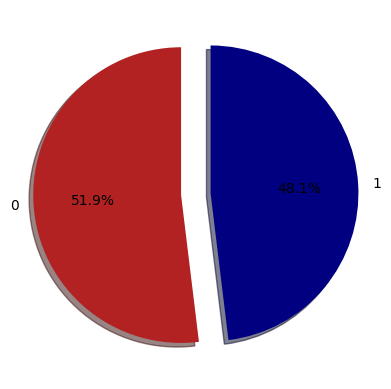

In [7]:
# Chequear si nuestros datos están bien balanceados
label_size = [df['real'].sum(), len(df['real']) - df['real'].sum()]
plt.pie(label_size, explode = [0.1,0.1], colors = ['firebrick','navy'], startangle = 90, shadow = True, labels = ['0', '1'], autopct = '%1.1f%%')

In [8]:
# Conjunto Prueba-Validación-Prueba dividido en un radio 70:15:15
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['real'].tolist(), stratify = df['real'], test_size = 0.3, random_state = 42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, stratify = temp_labels, test_size = 0.5, random_state = 42)

In [9]:
# Elegir modelo
model_name = "dccuchile/bert-base-spanish-wwm-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [10]:
# Tokenización
def tokenize(texts, max_len = 400):
    return tokenizer.batch_encode_plus(
        texts,
        padding = 'max_length',
        truncation = True,
        max_length = max_len,
        return_tensors = 'pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

In [11]:
# Crear DataLoaders
def create_dataset(encodings, labels):
    return TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

train_dataset = create_dataset(train_encodings, train_labels)
val_dataset = create_dataset(val_encodings, val_labels)
test_dataset = create_dataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size = 16)
val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = 16)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size = 16)

In [12]:
# Definir arquitectura
class BETOClassifier(nn.Module):
    def __init__(self, model_name):
        super(BETOClassifier, self).__init__()
        self.beto = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.beto.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.beto(input_ids = input_ids, attention_mask = attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BETOClassifier(model_name).to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Optimizador y criterio
optimizer = AdamW(model.parameters(), lr = 2e-5)
criterion = nn.CrossEntropyLoss()

In [14]:
# Entrenamiento y evaluación
def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim = 1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

In [17]:
# Entrenamiento
for epoch in range(3):
    loss = train_epoch(model, train_loader)
    print(f"Epoch {epoch+1} | Train Loss: {loss:.4f}")

Epoch 1 | Train Loss: 0.1407
Epoch 2 | Train Loss: 0.0449
Epoch 3 | Train Loss: 0.0203


In [18]:
# Evaluación final en test
preds, trues = evaluate(model, test_loader)
#print(classification_report(trues, preds, digits = 4))

              precision    recall  f1-score   support

           0     0.9744    0.8444    0.9048        45
           1     0.8727    0.9796    0.9231        49

    accuracy                         0.9149        94
   macro avg     0.9235    0.9120    0.9139        94
weighted avg     0.9214    0.9149    0.9143        94



In [ ]:
# Guardando los resultados

In [34]:
def save_metrics(trues, preds, model_name="model", csv_path="beto_metrics.csv"):
    report = classification_report(trues, preds, digits=4, output_dict=True)
    row = {
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Weighted Precision": report["weighted avg"]["precision"],
        "Weighted Recall": report["weighted avg"]["recall"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Class 0 F1": report["0"]["f1-score"],
        "Class 1 F1": report["1"]["f1-score"]
    }
    df = pd.DataFrame([row])
    df.to_csv(csv_path, index=False)
    print(f"Métricas guardadas en '{csv_path}'")

In [35]:
save_metrics(trues, preds, model_name="beto")


Métricas guardadas en 'beto_metrics.csv'
